### Fetching Data

In [16]:
# from SoccerNet.Downloader import SoccerNetDownloader as SNdl
# mySNdl = SNdl(LocalDirectory="path/to/SoccerNet")
# mySNdl.downloadDataTask(task="jersey-2023", split=["train","test","challenge"])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pathlib
import tensorflow as tf
import numpy as np
import os
import keras
import json
import cv2
from matplotlib import pyplot as plt
import zipfile
import torch
import torchvision
from torchvision import datasets, transforms
from sp_module import Net
from train import Network_Trainer
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
import torch.nn as nn
from DataSet import JerseyDataset

In [18]:
"""
This function will load the data and return two zipped arrays: 

output:       contains an image stored as a numpy array
class_labels: contains the corresponding label for each element of output

@params
dir: should be the path that contains both train images, and json dic with labels
save: If you want it to save the output as a zip file (so you don't have to do this twice)
"""

def load_data(dir, save = False):
    #labels is a dictionary mapping file_numer ->class_label
    with open(dir + "/train_gt.json") as file:
        labels = json.load(file)

    #converts an image to a numpy array
        
    """
    Eventually we will want to resize the images when we localize. This is just so that they are all the same size.
    """
    get_image = lambda file_name: cv2.resize(cv2.imread(file_name),(40, 100))

    output = []
    class_labels = []

    #iterate through the folders, convert the images to RGB arrays, and then append the class label
    for folder in list(os.listdir(dir+"/images")):

        if folder == '.DS_Store': continue
        #if (folder != '1' and folder != '2'): continue

        cls = labels[folder]
        images = os.listdir(os.path.join(dir+"/images", folder))

        for image in images:
            output.append(get_image(os.path.join(dir+"/images", folder, image)))
            class_labels.append(cls)

    zip_file = zip(output, class_labels)
    if save:
        np.savez_compressed(dir+"/numpy_data.npz", output, labels)
        
    return zip_file


def load_data_from_list(dir_train, dir_test, train_list = None, test_list = None):
        

        get_image = lambda file_name: cv2.resize(cv2.imread(file_name),(40, 100))

        #get train labels
        with open(dir_train + "/train_gt.json") as train_file:
            train_labels = json.load(train_file)

        #get test labels
        with open(dir_test + "/test_gt.json") as test_file:
            test_labels = json.load(test_file)
        
        # cls = labels[folder]

        images = []
        targets = []


        #get all the training images
        for index, train_image_name in enumerate(train_list):

            file_number = train_image_name.split('_')[0]

            image_path = dir_train + '/images/'+ file_number + '/'+ train_image_name + '.jpg'

            class_label = train_labels[file_number]
            targets.append(class_label)

            images.append(get_image(image_path))

        for index, test_image_name in enumerate(test_list):

            file_number = test_image_name.split('_')[0]

            image_path = dir_test + '/images/'+ file_number + '/'+ test_image_name + '.jpg'

            class_label = test_labels[file_number]
            targets.append(class_label)

            images.append(get_image(image_path))

        return images, targets


def load_small_data(dir):

    data = np.load(dir)
    lst = data.files
    X = data[lst[0]]
    y = data[lst[1]]

    return X,y

def resize(width, height, images):
    output = []

    for image in images: 
        output.append(cv2.resize(image, (width, height)))
    return output

In [19]:
dir_train = '/Users/omarafifi/Downloads/Jersey Detection/Data/SoccerNet/jersey-2023/train'
dir_test='/Users/omarafifi/Downloads/Jersey Detection/Data/SoccerNet/jersey-2023/test'
train_list = np.genfromtxt('/Users/omarafifi/Downloads/Jersey Detection/Data/Good Images/train_img_with_numbers.txt', dtype='str')
test_list = np.genfromtxt('/Users/omarafifi/Downloads/Jersey Detection/Data/Good Images/test_img_with_numbers.txt', dtype = 'str')

In [20]:
X, y = load_data_from_list(dir_train=dir_train,
                    dir_test= dir_test, train_list=train_list, test_list=test_list)


### Preprocessing

In [21]:
from keras import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, ZeroPadding2D
from sklearn.model_selection import train_test_split

In [22]:
# right now, there is no data processing. 
# But, We need to make sure that all the images have the same shape.
# and one hot encode y labels
def process_data(X_data, y_data):

    """
    Prepare the response:

    This part of the function just basically maps the classes to the set {0, ... 44}, and then one-hot encodes the response
    """
    #for to_categorical to work, we need to map the labels to {0, ... 44}
    label_to_int = {}
    int_to_label = {}

    for index, label in enumerate(np.unique(y_data)):
        label_to_int[label]=index
        int_to_label[index]=label

    
    y_data_new = np.vectorize(label_to_int.__getitem__)(y_data)
    y_data_new = to_categorical(y_data_new)

    #X_train, y_train = zip(*load_data(directory, True))
    X_data = np.array(X_data).reshape(-1, 3, 100, 40)


    return X_data, y_data_new


In [23]:
#IF USING THE MINIBATCH
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 64, stratify=y)
X_train, y_train = process_data(X_train, y_train)
X_test, y_test = process_data(X_test, y_test)

### Prepare data

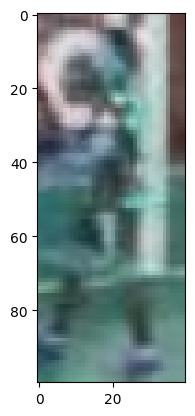

In [24]:
plt.imshow(X_train[130].reshape(100,40,3))

### Model Construction

### Fit the model

### The Spacial Transformer Network:

#### Choosing Hyperparamaters for training

In [31]:
learning_rate = 0.001
epochs = 100
batch_size =  24

#need to compute the means and standard deviations to batch normalize: 
means = X_train.mean(axis=(0,2,3))/255
devs = X_train.std(axis=(0,2,3))/255

sp_transform =transforms.Compose([

                    transforms.ToTensor(),
                    transforms.Normalize(means,devs)
                    ])

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


#### Prepping the data for training

In [32]:
spt = Net()
optimizer = optim.SGD(spt.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

train_tensor_x = torch.Tensor(X_train) # transform to torch tensor
train_tensor_y = torch.Tensor(y_train)

val_tensor_x = torch.Tensor(X_test) # transform to torch tensor
val_tensor_y = torch.Tensor(y_test)

train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
val_dataset = TensorDataset(val_tensor_x, val_tensor_y)

trainer = Network_Trainer(model = spt, 
                          transforms = sp_transform, criterion = criterion, 
                          epochs = epochs, device = device, optimizer = optimizer,
                          batch_size = batch_size, 
                          learning_rate = learning_rate, out_path = '/Users/omarafifi/Downloads/Jersey Detection/Data/Output Images')

In [33]:
train_data = JerseyDataset(X_train, y_train, sp_transform)
val_data = JerseyDataset(X_test, y_test, sp_transform)

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True )
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False)

In [36]:
trainer.train_model(train_loader, train_data, val_loader, val_data)

Epoch 1 of 20
Training


9it [00:00, 13.98it/s]                       


Validating


9it [00:00, 46.02it/s]                       


Train Loss: 0.1722, Train Acc: 5.50
Validation Loss: 0.1719, Val Acc: 8.50
Epoch 2 of 20
Training


9it [00:00, 14.68it/s]                       


Validating


9it [00:00, 44.70it/s]                       


Train Loss: 0.1722, Train Acc: 7.00
Validation Loss: 0.1718, Val Acc: 8.00
Epoch 3 of 20
Training


9it [00:00, 14.55it/s]                       


Validating


9it [00:00, 45.06it/s]                       


Train Loss: 0.1719, Train Acc: 7.50
Validation Loss: 0.1717, Val Acc: 8.50
Epoch 4 of 20
Training


9it [00:00, 13.86it/s]                       


Validating


9it [00:00, 49.42it/s]                       


Train Loss: 0.1717, Train Acc: 8.50
Validation Loss: 0.1715, Val Acc: 10.00
Epoch 5 of 20
Training


9it [00:00, 12.07it/s]                       


Validating


9it [00:00, 49.70it/s]                       


Train Loss: 0.1714, Train Acc: 10.00
Validation Loss: 0.1714, Val Acc: 10.50
Epoch 6 of 20
Training


9it [00:00, 14.84it/s]                       


Validating


9it [00:00, 51.24it/s]                       


Train Loss: 0.1715, Train Acc: 10.50
Validation Loss: 0.1712, Val Acc: 11.00
Epoch 7 of 20
Training


9it [00:00, 15.44it/s]                       


Validating


9it [00:00, 50.61it/s]                       


Train Loss: 0.1714, Train Acc: 13.50
Validation Loss: 0.1711, Val Acc: 11.00
Epoch 8 of 20
Training


9it [00:00, 12.44it/s]                       


Validating


9it [00:00, 50.47it/s]                       


Train Loss: 0.1711, Train Acc: 16.00
Validation Loss: 0.1709, Val Acc: 13.00
Epoch 9 of 20
Training


9it [00:00, 15.27it/s]                       


Validating


9it [00:00, 47.23it/s]                       


Train Loss: 0.1709, Train Acc: 17.00
Validation Loss: 0.1707, Val Acc: 13.50
Epoch 10 of 20
Training


9it [00:00, 15.18it/s]                       


Validating


9it [00:00, 48.03it/s]                       


Train Loss: 0.1708, Train Acc: 18.00
Validation Loss: 0.1705, Val Acc: 15.00
Epoch 11 of 20
Training


9it [00:00, 12.99it/s]                       


Validating


9it [00:00, 44.69it/s]                       


Train Loss: 0.1705, Train Acc: 18.00
Validation Loss: 0.1703, Val Acc: 15.50
Epoch 12 of 20
Training


9it [00:00, 16.01it/s]                       


Validating


9it [00:00, 45.61it/s]                       


Train Loss: 0.1700, Train Acc: 18.50
Validation Loss: 0.1701, Val Acc: 15.50
Epoch 13 of 20
Training


9it [00:00, 15.76it/s]                       


Validating


9it [00:00, 47.55it/s]                       


Train Loss: 0.1700, Train Acc: 18.50
Validation Loss: 0.1698, Val Acc: 17.00
Epoch 14 of 20
Training


9it [00:00, 13.88it/s]                       


Validating


9it [00:00, 50.44it/s]                       


Train Loss: 0.1694, Train Acc: 19.00
Validation Loss: 0.1695, Val Acc: 17.00
Epoch 15 of 20
Training


9it [00:00, 14.00it/s]                       


Validating


9it [00:00, 45.00it/s]                       


Train Loss: 0.1697, Train Acc: 19.00
Validation Loss: 0.1691, Val Acc: 16.50
Epoch 16 of 20
Training


9it [00:00, 15.64it/s]                       


Validating


9it [00:00, 46.14it/s]                       


Train Loss: 0.1694, Train Acc: 19.00
Validation Loss: 0.1688, Val Acc: 16.00
Epoch 17 of 20
Training


9it [00:00, 13.87it/s]                       


Validating


9it [00:00, 45.02it/s]                       


Train Loss: 0.1684, Train Acc: 19.00
Validation Loss: 0.1684, Val Acc: 16.00
Epoch 18 of 20
Training


9it [00:00, 13.87it/s]                       


Validating


9it [00:00, 47.60it/s]                       


Train Loss: 0.1685, Train Acc: 19.00
Validation Loss: 0.1680, Val Acc: 16.00
Epoch 19 of 20
Training


9it [00:00, 12.66it/s]                       


Validating


9it [00:00, 43.19it/s]                       


Train Loss: 0.1678, Train Acc: 19.00
Validation Loss: 0.1675, Val Acc: 16.00
Epoch 20 of 20
Training


9it [00:00, 14.55it/s]                       


Validating


9it [00:00, 47.62it/s]                       


Train Loss: 0.1671, Train Acc: 19.00
Validation Loss: 0.1670, Val Acc: 16.00


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105b67d90>>
Traceback (most recent call last):
  File "/Users/omarafifi/Downloads/Jersey Detection/jd_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


## Things To do: 

1) Use GridSearchCV to impletent CV so we can tune hyperparamaters